# Testing custom geometry

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.models import model_from_json
import json


2023-02-25 11:11:55.790042: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
Start,End = 14,20
for i in range(Start,End):
    i1,i2=str(i),str(i+1)
    if i < 18:
        V2 = '_V2'
    else:
        V2 = ''
    root_url = f"Data/CA-DBB_HH_20{i1}01010000_20{i2}01010000{V2}.csv"
    df = pd.read_csv(root_url,parse_dates=['TIMESTAMP_START'],na_values=-9999)
    df = df.set_index('TIMESTAMP_START')
    if i == Start:
        Data = df.copy()
    else:
        Data = pd.concat(
            [Data,df]
        )


print(Data.columns)
Data[['CO2', 'FC', 'FCH4', 'RH', 'TA', 'NETRAD', 'SW_IN', 'LW_OUT', 
    'P', 'TS_1_1_1', 'TS_1_2_1', 'TS_1_3_1', 'WTD',
       ]].describe()
# print(Data.loc[Data['USTAR']>.1,['FC','USTAR']].dropna().describe())
# Data[['FC','USTAR']].dropna().describe()

Index(['TIMESTAMP_END', 'CO2', 'FC', 'G', 'H', 'LE', 'WD', 'WS', 'USTAR', 'PA',
       'RH', 'TA', 'NETRAD', 'SW_IN', 'SW_OUT', 'LW_IN', 'LW_OUT', 'P',
       'T_SONIC', 'TS_1_1_1', 'TS_1_2_1', 'TS_1_3_1', 'WTD', 'FC_F', 'H_F',
       'LE_F', 'FCH4'],
      dtype='object')


,CO2,FC,FCH4,RH,TA,NETRAD,SW_IN,LW_OUT,P,TS_1_1_1,TS_1_2_1,TS_1_3_1,WTD
count,64827.000000,36765.000000,21877.000000,72252.000000,69838.000000,69104.000000,69539.000000,94472.000000,94412.000000,94752.000000,94765.000000,94482.000000,76679.000000
mean,441.575387,-0.787144,70.509587,82.563969,10.573513,81.035552,141.675786,370.937518,0.064427,12.007551,11.873606,11.621711,-0.077961
std,58.072862,2.796263,68.674930,16.013128,6.882273,178.738082,231.592218,43.751411,0.259551,5.535256,5.319778,3.673522,0.118576
min,208.022000,-73.607700,-199.641000,17.466101,-11.491303,-103.800000,0.000000,256.399170,0.000000,0.510000,0.770000,3.940000,-0.382820
25%,407.113500,-2.157400,17.800000,72.570000,5.969827,-23.091879,0.000000,340.963219,0.000000,6.959365,6.980000,8.025305,-0.169714
50%,422.280000,-0.506306,60.100000,87.711371,10.370411,-1.540000,3.410000,364.989000,0.000000,12.212890,12.188600,11.951013,-0.040143
75%,455.819000,0.562361,114.710000,95.787075,15.180000,119.402900,194.664058,393.540000,0.000000,17.070000,16.810000,15.050000,0.021700
max,986.500000,90.341600,687.649000,100.500000,32.430000,851.450000,1076.680000,521.450000,8.600000,25.354000,23.047600,17.421900,0.119653


In [3]:
def Calc_VPD(TA, RH):
    # Calculate vapour pressure (hPa)
    # From TA (in celsius) and RH %
    ea_H = 0.61365*np.exp((17.502*TA)/(240.97+TA))
    e_H = RH*ea_H/100
    VPD = ea_H - e_H
    VPD = np.round(VPD*10,5)     # Limit precision
    return (VPD)


Training_Data = Data[['FC','TS_1_1_1','TS_1_2_1','WTD','SW_IN','LW_IN','SW_OUT','LW_OUT','RH','TA']].dropna()

Training_Data['Month'] = Training_Data.index.month
Training_Data['DOY'] = Training_Data.index.dayofyear
Training_Data['HR'] = Training_Data.index.hour
Training_Data['VPD'] = Calc_VPD(Training_Data['TA'],Training_Data['RH'])

x_train_GPP = Training_Data[['SW_IN','LW_IN','SW_OUT','LW_OUT']].values
x_train_ER = Training_Data[['TS_1_1_1','TS_1_2_1']].values
y_train_NEE = Training_Data[['FC']].values

print(y_train_NEE.shape)
Training_Data.describe()

(23516, 1)


,FC,TS_1_1_1,TS_1_2_1,WTD,SW_IN,LW_IN,SW_OUT,LW_OUT,RH,TA,Month,DOY,HR,VPD
count,23516.000000,23516.000000,23516.000000,23516.000000,23516.000000,23516.000000,23516.000000,23516.000000,23516.000000,23516.000000,23516.000000,23516.000000,23516.000000,23516.000000
mean,-0.876536,13.959102,13.717938,-0.079615,278.098813,333.792323,33.808844,397.168884,74.589915,14.559257,6.184768,172.442805,11.851335,5.250539
std,2.291378,4.777132,4.614703,0.102927,287.850982,35.857758,32.585099,47.032309,16.531795,6.788614,2.520797,76.188428,5.834678,4.894766
min,-26.186100,1.980000,1.970000,-0.352014,0.000000,194.800000,0.000000,256.399170,19.848000,-8.446045,1.000000,8.000000,0.000000,0.000000
25%,-2.379170,10.411090,10.310000,-0.147926,0.215081,314.410750,2.051205,362.669721,63.050000,10.110000,4.000000,120.000000,8.000000,1.535775
50%,-0.619515,16.060000,15.821170,-0.067202,182.791546,339.280060,25.230050,393.545000,75.939525,15.090000,6.000000,172.000000,12.000000,3.821285
75%,0.616513,17.570000,17.217242,0.010431,506.367798,359.177000,62.170004,433.301414,88.410000,19.270070,8.000000,227.000000,16.000000,7.547490
max,21.763700,21.910000,20.860000,0.072483,1076.680000,420.109192,355.730000,521.450000,100.000000,32.360000,12.000000,352.000000,23.000000,35.789140


In [4]:
def make_model(GPP_shape,ER_shape,hidden_nodes):
    input_layer_GPP = keras.layers.Input(GPP_shape)
    GPP = keras.layers.Dense(
                            hidden_nodes,
                            activation='relu',
                            kernel_initializer="glorot_uniform",
                            bias_initializer="zeros",
                            )(input_layer_GPP)
                            
    GPP_out = keras.layers.Dense(
                            1,
                            )(GPP)
                                
    input_layer_ER = keras.layers.Input(ER_shape)
    ER = keras.layers.Dense(
                            hidden_nodes,
                            activation='relu',
                            kernel_initializer="glorot_uniform",
                            bias_initializer="zeros",
                            )(input_layer_ER)

    ER_out = keras.backend.abs(
                    keras.layers.Dense(
                            1,
                            )(ER)
                                )
                                
    ER_out = keras.layers.Dense(
                            1,
                            )(ER)

    NEE = keras.layers.Add()([ER_out, GPP_out])


    return keras.models.Model(inputs=[input_layer_GPP,input_layer_ER], outputs=NEE)


model = make_model(x_train_GPP.shape[1],
                    x_train_ER.shape[1],
                    42)
model.summary()

# keras.utils.plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 42)           126         ['input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 42)           210         ['input_1[0][0]']                
                                                                                              

2023-02-25 11:12:02.642494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-25 11:12:02.651938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-25 11:12:02.651978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-25 11:12:02.652488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

In [5]:
# import tensorflow as tf
# from tensorflow import keras
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn import metrics


# # def make_model(GPP_shape,ER_shape,hidden_nodes):
# def make_model(Layer_Shapes,hidden_nodes,name='Model'):
#     try:
#         os.mkdir(f"temp_files/{name}")
#     except:
#         pass
#     tf.keras.backend.clear_session()
#     Inputs = []
#     Layers = []
#     for shape in Layer_Shapes:
#         print(shape,hidden_nodes)
#         Inputs.append(keras.layers.Input(shape))
#         Hidden = keras.layers.Dense(
#                                 hidden_nodes,
#                                 activation='relu',
#                                 kernel_initializer="glorot_uniform",
#                                 bias_initializer="zeros",
#                                 )(Inputs[-1])
#         Layers.append(
#             keras.layers.Dense(
#                                 1,
#                                 )(Hidden)
#                                 )
                              
#     Cat = keras.layers.Concatenate(axis=1)(Layers)
#     Out = keras.layers.Dense(
#                                 1,
#                                 )(Cat)


#     model = keras.models.Model(inputs=Inputs, outputs=Out)

#     model_json = model.to_json()
#     with open(f"temp_files/{name}/model_architecture.json", "w") as json_file:
#         json_file.write(model_json)


#     print(model.summary())
    
#     return(model)


# model = make_model([4,2],4,name='NewModel')

# keras.utils.plot_model(model, show_shapes=True)

# # model_json = model.to_json()
# # print(model_json)


In [6]:
epochs = 250
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "temp_files/Custom_Model/best_model.h5", save_best_only=True, monitor="val_loss", verbose=1
    ),
    # keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
    # ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, verbose=1),
]

model.compile(
    optimizer="adam",
    loss="mean_squared_error",
)

history = model.fit(
    [x_train_GPP,x_train_ER],
    y_train_NEE,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=0,
)

2023-02-25 11:12:04.829122: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



Epoch 1: val_loss improved from inf to 10.14921, saving model to temp_files/Custom_Model/best_model.h5

Epoch 2: val_loss improved from 10.14921 to 2.93757, saving model to temp_files/Custom_Model/best_model.h5

Epoch 3: val_loss did not improve from 2.93757

Epoch 4: val_loss improved from 2.93757 to 2.12049, saving model to temp_files/Custom_Model/best_model.h5

Epoch 5: val_loss did not improve from 2.12049

Epoch 6: val_loss did not improve from 2.12049

Epoch 7: val_loss improved from 2.12049 to 1.95378, saving model to temp_files/Custom_Model/best_model.h5

Epoch 8: val_loss did not improve from 1.95378

Epoch 9: val_loss did not improve from 1.95378

Epoch 10: val_loss did not improve from 1.95378

Epoch 11: val_loss did not improve from 1.95378

Epoch 12: val_loss did not improve from 1.95378

Epoch 13: val_loss did not improve from 1.95378

Epoch 14: val_loss did not improve from 1.95378

Epoch 15: val_loss improved from 1.95378 to 1.93203, saving model to temp_files/Custom_M

In [7]:

with open(f"temp_files/NewModel/model_architecture.json", 'r') as json_file:
    architecture = json.load(json_file)
    model = model_from_json(json.dumps(architecture))
model = keras.models.load_model("temp_files/Custom_Model/best_model.h5")

W = model.get_weights()
# print(len(W))
# for w in W:
#     print(w.shape)
# print()
# Layers = architecture['config']['layers']
# print(len(Layers))
# for L in Layers:
#     print(L['config'])


In [8]:
# for w in model.weights:
#     print(w.name)
#     print(w.numpy().shape)
#     # print(w.value)
# # W = model.weights[0]


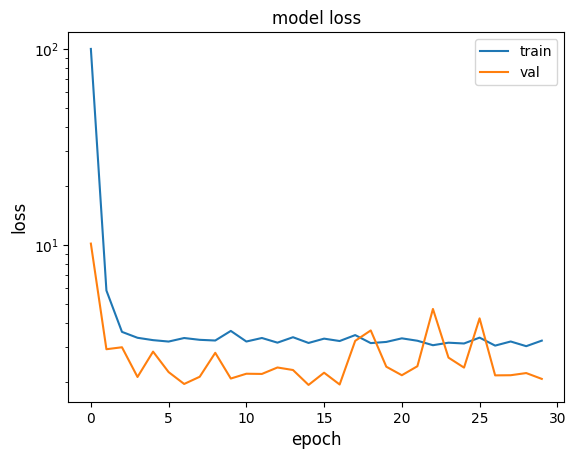

735/735 [==============================] - 1s 2ms/step
0.5353306958073307
1.5619225556308565


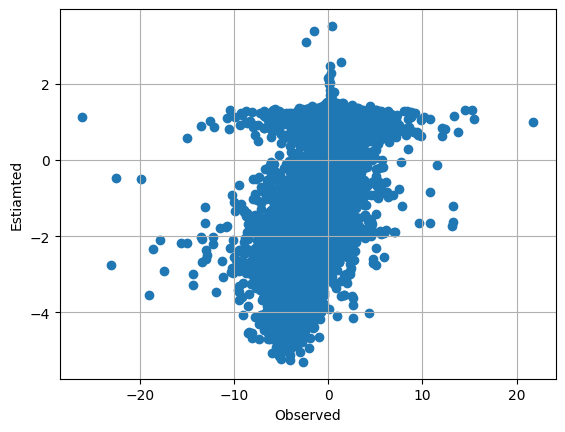

In [9]:

    
# test_loss = model.evaluate([x_train_GPP,x_train_ER], y_train_NEE)
# print("Test loss", test_loss)
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.yscale('log')
plt.show()
plt.close()

pred = model.predict([x_train_GPP,x_train_ER])

fig,ax=plt.subplots()
ax.scatter(y_train_NEE,pred)
ax.set_ylabel('Estiamted')
ax.set_xlabel('Observed')
# ax.set_ylim(ax.get_xlim())
ax.grid()
print(metrics.r2_score(y_train_NEE,pred))
print(metrics.mean_squared_error(y_train_NEE,pred)**.5)

8
(2, 42)
(42,)
(4, 42)
(42,)
(42, 1)
(1,)
(42, 1)
(1,)


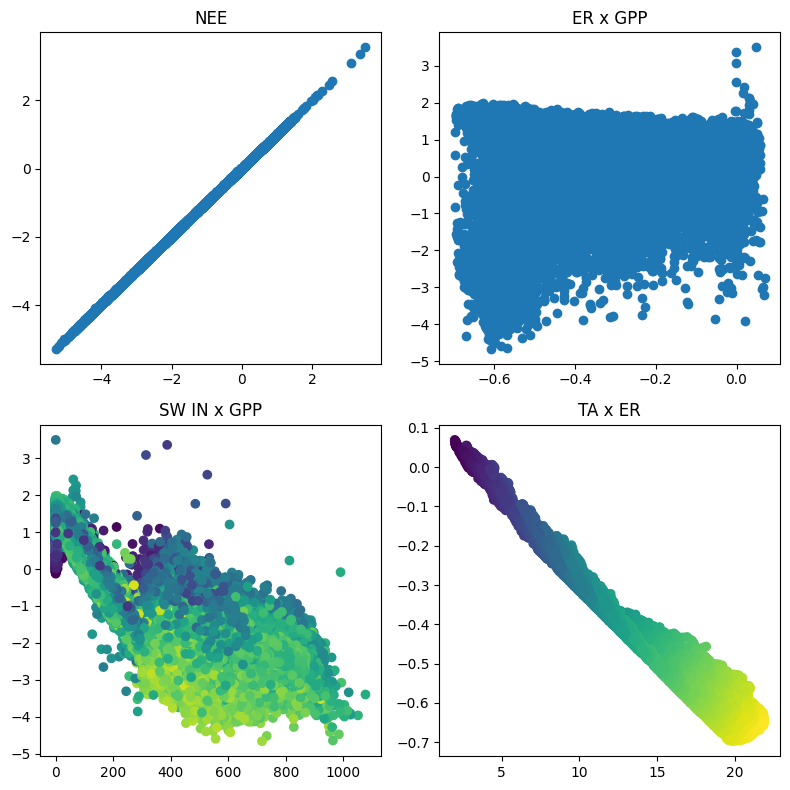

In [10]:
W = model.get_weights()
print(len(W))
for w in W:
    print(w.shape)

W_i_ER = (W[0])
W_i_ER_T = (W[0].T)

W_i_GPP = (W[2])
W_i_GPP_T = (W[2].T)

W_d_i_ER = (W[1])
W_d_i_GPP = (W[3])

W_d_o_ER = (W[4])
W_d_o_ER_T = (W[4].T)

W_d_o_GPP = (W[6])
W_d_o_GPP_T = (W[6].T)

W_o_ER = (W[5])
W_o_GPP = (W[7])

# w_do_i = (W[8])
# w_do_o = (W[9])


Op_GPP = []
for i in range(y_train_NEE.shape[0]):
    Ip_GPP = x_train_GPP[i]
    H1_GPP = (Ip_GPP*W_i_GPP_T).sum(axis=-1)+W_d_i_GPP
    # First derivative of the relu function
    # If using Sigmoid function, change to - H1 = 1/(1+np.exp(-H1))
    H1_GPP = np.maximum(H1_GPP,np.zeros(H1_GPP.shape))
    H2_GPP = (H1_GPP*W_d_o_GPP_T).sum(axis=-1)+W_o_GPP
    # H2_GPP = np.maximum(H2_GPP,np.zeros(H2_GPP.shape))
    Op_GPP.append(H2_GPP)# - .diagonal()  needed if doing multiple models at onece 
Estimates_GPP = np.array(Op_GPP)


Op_ER = []
for i in range(y_train_NEE.shape[0]):
    Ip_ER = x_train_ER[i]
    H1_ER = (Ip_ER*W_i_ER_T).sum(axis=-1)+W_d_i_ER
    # First derivative of the relu function
    # If using Sigmoid function, change to - H1 = 1/(1+np.exp(-H1))
    H1_ER = np.maximum(H1_ER,np.zeros(H1_ER.shape))
    H2_ER = (H1_ER*W_d_o_ER_T).sum(axis=-1)+W_o_ER
    # H2_ER = np.maximum(H2_ER,np.zeros(H2_ER.shape))
    Op_ER.append(H2_ER)# - .diagonal()  needed if doing multiple models at onece 
Estimates_ER = np.array(Op_ER)

Estimates_NEE = Estimates_ER+Estimates_GPP

# Estimates_NEE = (Estimates_NEE*w_do_i).sum(axis=-1)+w_do_o

fig,axes=plt.subplots(2,2,figsize=(8,8))
ax = axes[0,0]
ax.scatter(pred,Estimates_NEE)
ax.set_title('NEE')

ax = axes[0,1]
ax.scatter(Estimates_ER,Estimates_GPP)
ax.set_title('ER x GPP')

ax = axes[1,0]
ax.scatter(x_train_GPP[:,0],Estimates_GPP,c=x_train_GPP[:,1])
ax.set_title('SW IN x GPP')

ax = axes[1,1]
ax.scatter(x_train_ER[:,0],Estimates_ER,c=x_train_ER[:,1])
ax.set_title('TA x ER')

plt.tight_layout()

In [11]:
SSD = []
SAD = []
Derivs = []
# print(W_d_o_GPP.shape)
for i in range(x_train_GPP.shape[1]):
    dj_GPP=[]
    for j in range(y_train_NEE.shape[0]):
        target = y_train_NEE[j]
        Xj = x_train_GPP[j][i]
        if np.isnan(target)==False:
            H1_GPP = (Xj*W_i_GPP_T).sum(axis=-1)+W_d_i_GPP
            AD = np.maximum(H1_GPP,np.zeros(H1_GPP.shape))
            AD[AD>0]=1
            # Sum = np.array([AD[h]*W_d_o_GPP[h]*W_i_GPP[i,h] for h in range(W_d_o_GPP.shape[0])]).sum(axis=0)
            # print(Sum)
            # print(AD.shape,W_d_o_GPP.shape,W_i_GPP[i].shape)
            Sum = (AD*W_d_o_GPP[:,0]*W_i_GPP[i]).sum(axis=0)
            # print(Sum)
            Sj = 1
            dj_GPP.append(Sj*Sum)
    dji_GPP = np.array(dj_GPP)#*w_do_i
    print(dji_GPP.shape)
    Derivs.append(dji_GPP)



for i in range(x_train_ER.shape[1]):
    dj_ER=[]
    for j in range(y_train_NEE.shape[0]):
        target = y_train_NEE[j]
        Xj = x_train_ER[j][i]
        if np.isnan(target)==False:
            H1_ER = (Xj*W_i_ER_T).sum(axis=-1)+W_d_i_ER
            AD = np.maximum(H1_ER,np.zeros(H1_ER.shape))
            AD[AD>0]=1
            # Sum = np.array([AD[h]*W_d_o_ER[h]*W_i_ER[i,h] for h in range(W_d_o_ER.shape[0])]).sum(axis=0)
            Sum = (AD*W_d_o_ER[:,0]*W_i_ER[i]).sum(axis=0)
            # print(Sum)
            Sj = 1
            dj_ER.append(Sj*Sum)
    # print(dj_GPP.mean())
    dji_ER = np.array(dj_ER)#*w_do_i
    print(dji_ER.shape)
    Derivs.append(dji_ER)

#     SSD.append(np.sum(dji**2,axis=0))
#     SAD.append(np.sum(np.abs(dji),axis=0))
# Derivs = np.array(Derivs)
# SSD = np.array(SSD)
# RI_SSD = SSD/SSD.sum(axis=0)
# SAD = np.array(SAD)
# RI_SAD = SAD/SAD.sum(axis=0)

(23516,)
(23516,)
(23516,)
(23516,)
(23516,)
(23516,)


(23516,)

(23516,)

(23516,)

(23516,)

(23516,)

(23516,)



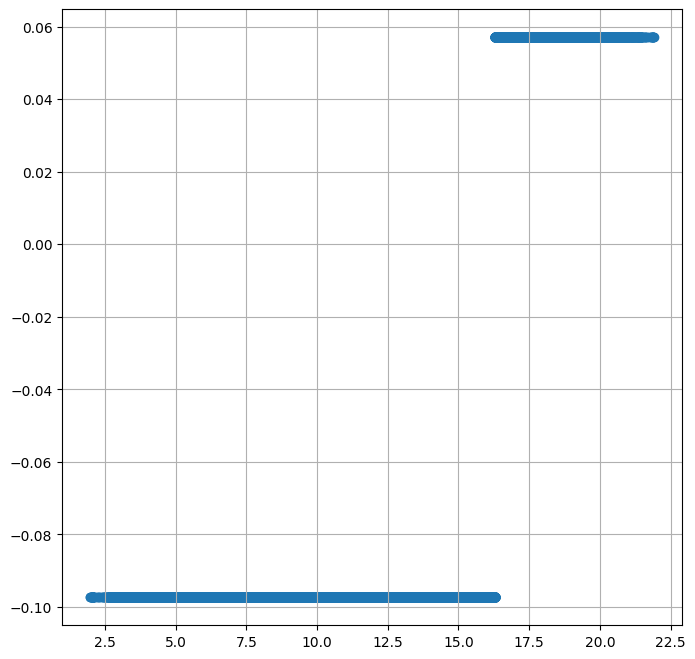

In [12]:

for d in Derivs:
    
    print(d.shape)
    print()
fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(x_train_ER[:,0],Derivs[4])
# ax.set_xlim(-1,1)
ax.grid()